In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]
print("Number of M*-complete SDSS galaxies with good profile measurements = {0}".format(len(sdss)))

Number of M*-complete SDSS galaxies with good profile measurements = 229889


In [3]:
from scipy.stats import binned_statistic

logsm_bins = np.linspace(9.5, 12, 20)
logsm_table = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_rhalf_table, __, __ = binned_statistic(sdss['logsm_bell03_meert15'], 
                                      sdss['r50_magr_kpc_meert15'], 
                                     bins=logsm_bins)

def frac_surviving_mstar(frac_surviving_dm, a=14.2):
    return 1 - np.exp(-a*frac_surviving_dm)

def frac_rhalf_reduction(mstar_init, frac_surviving_dm, a=14.2):
    mstar_final = frac_surviving_mstar(frac_surviving_dm)*mstar_init
    logsm_init, logsm_final = np.log10([mstar_init, mstar_final])
    initial_rhalf, final_rhalf = np.interp([logsm_init, logsm_final], 
                                          logsm_table, median_rhalf_table)
    return final_rhalf/initial_rhalf



In [4]:
from galsize_models.models import moster13_based_mock, load_baseline_halocat
mock = moster13_based_mock()
print("Number of model galaxies with logM* > {0:.1f} = {1:.2e}".format(np.log10(mock['mstar'].min()),len(mock)))

Number of model galaxies with logM* > 9.0 = 1.21e+06


In [5]:
from galsize_models.models import component_size_vs_rhalo

rvir = mock['rvir_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.15
size_seed=14041

mock['r50'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed)

mock['r50_orig'] = mock['r50']

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

from galsize_models.measurements import single_component_ratios
result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock, fracdiff_sm10p25_mock, \
fracdiff_sm10p75_mock, fracdiff_sm11p25_mock = result

In [6]:
frac_surviving_dm = mock['mvir']/mock['mpeak']
mock['r50'] = mock['r50_orig']*frac_rhalf_reduction(mock['mstar'], frac_surviving_dm)

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock_stripping, fracdiff_sm10p25_mock_stripping, \
fracdiff_sm10p75_mock_stripping, fracdiff_sm11p25_mock_stripping = result

In [7]:
mock['r50'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all, seed=size_seed, 
                        uran=1-mock['vmax_at_mpeak_percentile'])

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar']), mock['r50'], bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

from galsize_models.measurements import single_component_ratios
result = single_component_ratios(mock, num_gals_max=int(2e5))
rp_mids, fracdiff_sm9p75_mock2, fracdiff_sm10p25_mock2, \
fracdiff_sm10p75_mock2, fracdiff_sm11p25_mock2 = result

In [8]:
import os
repo_dirname = "/Users/aphearin/work/repositories/python/galsize_models"
output_subdirname = "galsize_models/measurements/data/two_point_functions"
output_dirname = os.path.join(repo_dirname, output_subdirname)

rp = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_rp.npy'))
wp_sdss_sm9p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_wp.npy'))
wp_sdss_sm9p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_small_wp.npy'))
wp_sdss_sm9p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm9p75_smbell_large_wp.npy'))
fracdiff_sm9p75_smbell = (wp_sdss_sm9p75_smbell_large-wp_sdss_sm9p75_smbell_small)/wp_sdss_sm9p75_smbell

wp_sdss_sm10p0_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_wp.npy'))
wp_sdss_sm10p0_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_small_wp.npy'))
wp_sdss_sm10p0_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p0_smbell_large_wp.npy'))
fracdiff_sm10p0_smbell = (wp_sdss_sm10p0_smbell_large-wp_sdss_sm10p0_smbell_small)/wp_sdss_sm10p0_smbell

wp_sdss_sm10p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_wp.npy'))
wp_sdss_sm10p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_small_wp.npy'))
wp_sdss_sm10p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p25_smbell_large_wp.npy'))
fracdiff_sm10p25_smbell = (wp_sdss_sm10p25_smbell_large-wp_sdss_sm10p25_smbell_small)/wp_sdss_sm10p25_smbell

wp_sdss_sm10p5_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_wp.npy'))
wp_sdss_sm10p5_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_small_wp.npy'))
wp_sdss_sm10p5_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p5_smbell_large_wp.npy'))
fracdiff_sm10p5_smbell = (wp_sdss_sm10p5_smbell_large-wp_sdss_sm10p5_smbell_small)/wp_sdss_sm10p5_smbell

wp_sdss_sm10p75_smbell = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_wp.npy'))
wp_sdss_sm10p75_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_small_wp.npy'))
wp_sdss_sm10p75_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm10p75_smbell_large_wp.npy'))
fracdiff_sm10p75_smbell = (wp_sdss_sm10p75_smbell_large-wp_sdss_sm10p75_smbell_small)/wp_sdss_sm10p75_smbell

wp_sdss_sm11_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_wp.npy'))
wp_sdss_sm11_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_small_wp.npy'))
wp_sdss_sm11_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11_smbell_large_wp.npy'))
fracdiff_sm11_smbell = (wp_sdss_sm11_smbell_large-wp_sdss_sm11_smbell_small)/wp_sdss_sm11_smbell

wp_sdss_sm11p25_smbell = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_wp.npy'))
wp_sdss_sm11p25_smbell_small = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_small_wp.npy'))
wp_sdss_sm11p25_smbell_large = np.load(os.path.join(output_dirname, 'sdss_sm11p25_smbell_large_wp.npy'))
fracdiff_sm11p25_smbell = (wp_sdss_sm11p25_smbell_large-wp_sdss_sm11p25_smbell_small)/wp_sdss_sm11p25_smbell

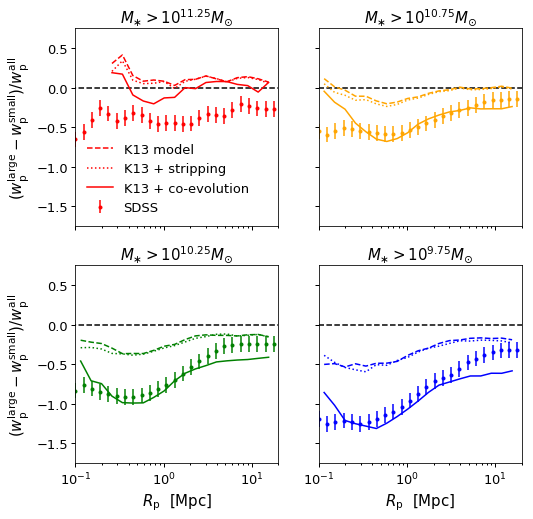

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                             figsize=(8, 8))

axes = ax1, ax2, ax3, ax4

for ax in axes:
    ylim = ax.set_ylim(-1.75, 0.75)
    xlim = ax.set_xlim(0.1, 20)
    xscale = ax.set_xscale('log')
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

    
__=ax1.errorbar(rp, fracdiff_sm11p25_smbell, 0.1, fmt='.', color='red', label='SDSS')
__=ax2.errorbar(rp, fracdiff_sm10p75_smbell, 0.1, fmt='.', color='orange')
__=ax3.errorbar(rp, fracdiff_sm10p25_smbell, 0.1, fmt='.', color='green')
__=ax4.errorbar(rp, fracdiff_sm9p75_smbell, 0.1, fmt='.', color='blue')

__=ax1.plot(rp_mids[3:], fracdiff_sm11p25_mock[3:],'--', color='red', 
            label=r'K13 model')
__=ax2.plot(rp_mids, fracdiff_sm10p75_mock, '--', color='orange')
__=ax3.plot(rp_mids, fracdiff_sm10p25_mock,'--', color='green')
__=ax4.plot(rp_mids, fracdiff_sm9p75_mock,'--', color='blue')

__=ax1.plot(rp_mids[3:], fracdiff_sm11p25_mock_stripping[3:], ':', color='red', 
            label=r'K13 + stripping')
__=ax2.plot(rp_mids, fracdiff_sm10p75_mock_stripping, ':', color='orange')
__=ax3.plot(rp_mids, fracdiff_sm10p25_mock_stripping, ':', color='green')
__=ax4.plot(rp_mids, fracdiff_sm9p75_mock_stripping,':', color='blue')

__=ax1.plot(rp_mids[3:], fracdiff_sm11p25_mock2[3:], color='red', 
            label=r'K13 + co-evolution')
__=ax2.plot(rp_mids, fracdiff_sm10p75_mock2, color='orange')
__=ax3.plot(rp_mids, fracdiff_sm10p25_mock2, color='green')
__=ax4.plot(rp_mids, fracdiff_sm9p75_mock2, color='blue')

__=ax1.set_title(r'$M_{\ast} > 10^{11.25}M_{\odot}$')
__=ax2.set_title(r'$M_{\ast} > 10^{10.75}M_{\odot}$')
__=ax3.set_title(r'$M_{\ast} > 10^{10.25}M_{\odot}$')
__=ax4.set_title(r'$M_{\ast} > 10^{9.75}M_{\odot}$')

ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')

leg1 = ax1.legend()

figname = 'size_clustering_ratios_stripping_coevolution.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [20]:
mpeak_mask = (mock['mpeak'] > 1e13) & (mock['mpeak'] < 2.5e13)
sample = mock[mpeak_mask]

In [21]:
sample.sort('vmax_at_mpeak_percentile')

In [22]:
sample['r50'][:1000].mean(), sample['r50'][-1000:].mean()

(14.667378956812934, 5.4154354515471503)

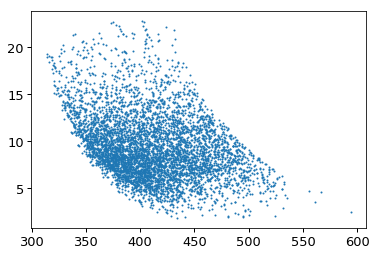

In [23]:
fig, ax = plt.subplots(1, 1)

__=ax.scatter(sample['vmax_mpeak'], sample['r50'], s=1)

In [18]:
sample.keys()

['upid',
 'mpeak',
 'scale_factor_mpeak',
 'x',
 'y',
 'z',
 'zpeak',
 'vmax_mpeak',
 'mvir',
 'scale_factor_firstacc',
 'mvir_firstacc',
 'halfmass_scale_factor',
 'vx',
 'vy',
 'vz',
 'rvir_zpeak',
 'vmax_at_mpeak_percentile',
 'mvir_host_halo',
 'spin',
 'uran',
 'mstar',
 'mstar_moster13',
 'r50',
 'r50_orig',
 'r50_median']